# Predicting Taxi wait time 

-The goal of this project is to develop a model that predicts 'wait_sec' as well as possible, so we can correctly estimate   the wait time for the customer and provide a better experience to customers using the App.

-In this project we mainly want to minimize the MAE, i.e. the mean absolute error. This is a metric that is easy to           interpret and gives a stable value in regression problems.


Column name	                    Description

'id'		                  	A unique identification number for every row
'vendor_id' 	       	        Name of taxi company used
'pickup_datetime'	        	Date and time at journey start
'pickup_longitude'	  	        Longitude where journey started
'pickup_latitude'	        	Latitude where journey started
'dropoff_longitude' 	    	Destination longitude
'dropoff_latitude'	        	Destination latitude
'store_and_fwd_flag'  	      	Indicates whether data was cached for a long time (Y) or went was                                                                transferred directly to the server (N)
'trip_duration'	        	Estimated journey time without taking traffic into account (seconds)
'dist_meters'	                distance between pickup and arrival location
'wait_sec'	        	        Duration that passengers were stuck in traffic (seconds). The vehicle was                                                        completely stationary during this time.

Gathering data 

In [1]:
# import modules

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')


In [2]:
# read data
df = pd.read_csv(r'C:\Users\Acer\Downloads\Quito-Taxis.csv')

# EDA

In [3]:
#check basic information
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 9:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 4:03:20,2016-09-18 4:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 6:29:36,2016-09-18 6:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 5:57:47,2016-09-18 6:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 7:58:42,2016-09-18 8:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314


In [4]:
#checking data types
df.dtypes

id                      int64
vendor_id              object
pickup_datetime        object
dropoff_datetime       object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dist_meters             int64
wait_sec                int64
dtype: object

In [5]:
#check objects
print('df length: ', len(df))
print('vendor_id unique: ', df.vendor_id.unique())
print('vendor_id unique counts: ', df.vendor_id.value_counts())
print('store_and_fwd_flag unique: ', df.store_and_fwd_flag.unique())
print('store_and_fwd_flag unique counts: ', df.store_and_fwd_flag.value_counts())
#note: vendor id mostly consists of 'Quito'
#note: store_and_fwd_flag is all 'N', can be removed

df length:  32366
vendor_id unique:  ['Quito' 'Quito Cabify Lite' 'Quito Cabify Executive' 'Quito UberX']
vendor_id unique counts:  Quito                     31875
Quito Cabify Lite           400
Quito Cabify Executive       88
Quito UberX                   3
Name: vendor_id, dtype: int64
store_and_fwd_flag unique:  ['N']
store_and_fwd_flag unique counts:  N    32366
Name: store_and_fwd_flag, dtype: int64


In [6]:
#check NaNs and duplicates
print('index_size', df.index.size)
print('is NaN', df.isna().sum())
print('duplicated', df.duplicated().sum())
#note: no NaNs, no duplicates, no cleaning required

index_size 32366
is NaN id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64
duplicated 0


In [7]:
# check distribution of values in each feature
display(df.describe())
display(sns.pairplot(df))

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,32366.000000,32366.000000,32366.000000,32366.000000,32366.000000,3.236600e+04,3.236600e+04,3.236600e+04
mean,16183.500000,-78.492371,-0.189042,-78.492901,-0.191341,4.138239e+04,7.302745e+04,2.204058e+07
std,9343.403743,0.043108,0.076153,0.044783,0.085623,5.842226e+05,1.193671e+07,7.311736e+08
min,1.000000,-80.681697,-3.454279,-80.681721,-3.574739,-3.887110e+05,1.100000e+01,0.000000e+00
25%,8092.250000,-78.505867,-0.218344,-78.505734,-0.220508,5.000000e+02,2.148000e+03,1.070000e+02
50%,16183.500000,-78.490135,-0.181979,-78.490073,-0.185721,8.970000e+02,4.124000e+03,2.430000e+02
75%,24274.750000,-78.475783,-0.148715,-78.477443,-0.149867,1.710000e+03,7.475000e+03,4.990000e+02
max,32366.000000,-78.009669,0.866441,-77.710158,0.866759,7.002605e+07,2.147484e+09,9.516306e+10


(-0.4, 0.05)

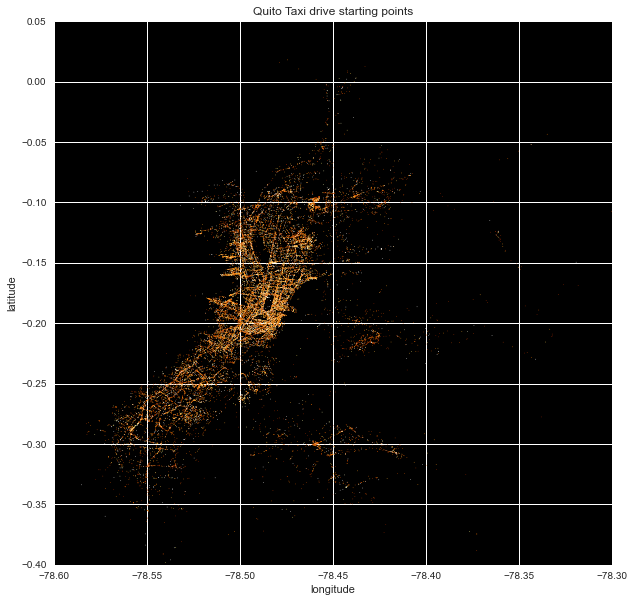

In [8]:
# import median absolute deviation (mad) from statsmodels and visualize data
from statsmodels.robust import mad

plt.figure(figsize=(10, 10))
plt.title('Quito Taxi drive starting points')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(df.pickup_longitude, df.pickup_latitude, c=df.wait_sec, s=0.1, cmap='afmhot')
plt.gca().set_facecolor('black')

median = df.loc[:, 'wait_sec'].median()
mad_value = mad(df.loc[:, 'wait_sec'])
plt.clim(median - 3 * mad_value, median + 3 * mad_value)
plt.xlim([-78.6, -78.3])
plt.ylim([-0.4, 0.05])

# Outlier detection

In [10]:
#import modules for outlier detection
from sklearn.linear_model import RANSACRegressor

In [11]:
df = df.rename(columns={'trip_duration': 'trip_estimated'})
df = df.rename(columns={'dist_meters': 'distance_m'})


Text(0.5, 0, 'trip_estimated')

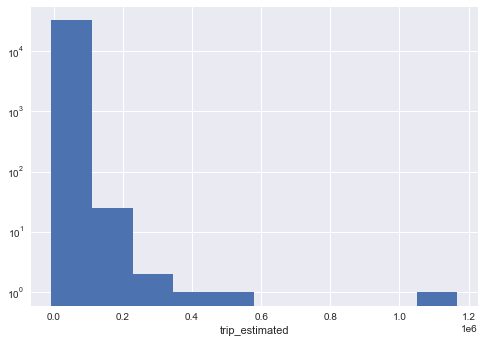

In [12]:
#histogram of trip_estimated showing outliers
df['trip_estimated'] = df['trip_estimated'] / 60 
df.trip_estimated.hist()
plt.gca().set_yscale('log')
plt.xlabel('trip_estimated')
#change scale to minutes

In [13]:
# find outliers in trip_estimated using RANSAC

d_distance = mad(df.loc[:, 'distance_m']) * 3

model_outlier = RANSACRegressor(residual_threshold=d_distance, random_state=0)
model_outlier.fit(X=df.loc[:, ['trip_estimated']], y=df.loc[:, 'distance_m'])

(~model_outlier.inlier_mask_).sum()

4088

(0.0, 10000.0)

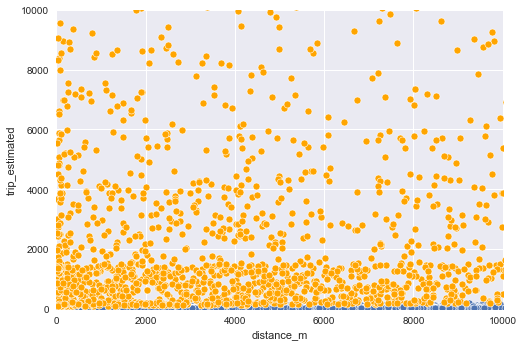

In [14]:
# visualize outliers with RANSAC

ax = sns.scatterplot(x=df.loc[model_outlier.inlier_mask_, 'distance_m'],
                     y=df.loc[model_outlier.inlier_mask_, 'trip_estimated'])

sns.scatterplot(x=df.loc[~model_outlier.inlier_mask_, 'distance_m'],
                y=df.loc[~model_outlier.inlier_mask_, 'trip_estimated'],
                color='orange', 
                ax=ax)

ax.set_ylim([0, 1e4])
ax.set_xlim([0, 1e4])

<AxesSubplot:>

<AxesSubplot:>

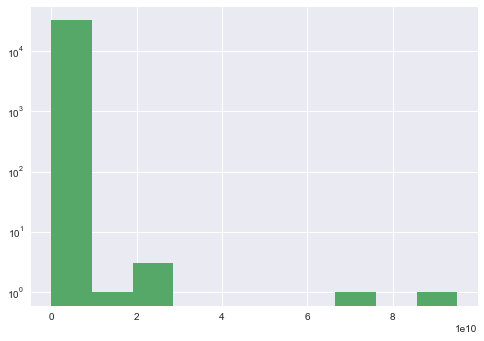

In [15]:
#histograms for outliers
display(df.distance_m.hist())
plt.gca().set_yscale('log')

display(df.wait_sec.hist())
plt.gca().set_yscale('log')

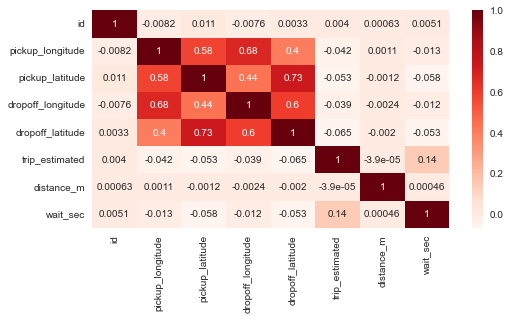

In [16]:
#check correlations using Pearson Correlation

plt.figure(figsize=(8, 4))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
#note: only the coordinates are highly correlated, which is expected

In [17]:
#Training/test split

In [18]:
# read data again to remove any previous changes to avoid data leakage 
df = pd.read_csv(r'C:\Users\Acer\Downloads\Quito-Taxis.csv')

df = df.rename(columns={'trip_duration': 'trip_estimated'})
df = df.rename(columns={'dist_meters': 'distance_m'})

df=df[(df['trip_estimated'].between(30,7200)) & (df['distance_m'].between(100,100000)) & (df['trip_estimated']>df['wait_sec'])]
df=df[df['wait_sec'].between(0,7200)]
df=df[(df['pickup_longitude'].between(-80,-77)) & (df['pickup_latitude'].between(-4,1)) & (df['dropoff_longitude'].between(-80,-77))
      &(df['dropoff_latitude'].between(-4,1))]

In [19]:
# perform train-test-split

from sklearn.model_selection import train_test_split

target = df.loc[:,'wait_sec']
features = df.drop('wait_sec', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,  
                                                                            test_size = 0.1)

In [20]:
# save features_test as 'features_test.csv'

features_test.to_csv('features_test.csv', index=False)


# Data preperation 

In [22]:
#Transforming data types

In [23]:
#copy target_train

df = features_train.copy()

In [24]:
#change datetime

df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])

In [25]:
# data cleaning

In [26]:
# clean_data function
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Transform datatypes:
        -transform 'pickup_datetime' to datetime format
    
    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    
    """
    #to datetime
    df['pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
   
    #no NaNs, so no more steps necessary
    
    return df

In [27]:
#Dealing with outliers

#there are 3 ways to deal with outliers:

#Delete outliers (either delete the data points or just mark the value as NaN).
#Replace outlier values (with a consistent extreme value that is still "acceptable", or with data imputation - using a probable value).
#Minimize the influence of outliers (transform features or use robust methods).

In [28]:
#remove latitude and longitude out of range: [-0.4, 0.05][-78.6, -78.3]

df = df[(df['pickup_longitude'] >= -78.6) & (df['pickup_longitude'] <= -78.3)]
df = df[(df['dropoff_longitude'] >= -78.6) & (df['dropoff_longitude'] <= -78.3)]
df = df[(df['pickup_latitude'] >= -0.4) & (df['pickup_latitude'] <= 0.05)]
df = df[(df['dropoff_latitude'] >= -0.4) & (df['dropoff_latitude'] <= 0.05)]

In [29]:
#removing outliers in trip_estimated with RANSAC

#first the median absolute deviation
d_dist = mad(df.loc[:, 'distance_m']) * 3

model_outlier = RANSACRegressor(residual_threshold=d_dist, random_state=0)
model_outlier.fit(X=df.loc[:, ['trip_estimated']],
                  y=df.loc[:,'distance_m'])

df = df.loc[model_outlier.inlier_mask_, :]

In [30]:
df.shape

(23503, 11)

In [31]:
#sampling function

def sampling_data(features, target):
    """Sample Dataframe.
    Only keeping datapoints that are not outliers.

    Keeping only the coordinates in the region of Quito.
    Removing outliers in 'trip_estimated' with RANSAC.
    """

    #creating mask
    mask = np.ones(len(features), np.bool)
    #remove latitude and longitude out of range: 
    #[-0.4,0.05][-78.6,-78.3]
    mask[(features['pickup_longitude'] <= -78.6) | (features['pickup_longitude'] >= -78.3)] = False
    mask[(features['dropoff_longitude'] <= -78.6) | (features['dropoff_longitude'] >= -78.3)] = False
    mask[(features['pickup_latitude'] <= -0.4) | (features['pickup_latitude'] >= 0.05)] = False
    mask[(features['dropoff_latitude'] <= -0.4) | (features['dropoff_latitude'] >= 0.05)] = False

    #removing outliers in trip_estimated with ransac
    #first the median absolute deviation
    d_dist = mad(features.loc[:, 'distance_m']) * 3

    model_outlier = RANSACRegressor(residual_threshold=d_dist, random_state=0)
    model_outlier.fit(X=features.loc[:, ['trip_estimated']], 
                      y=features.loc[:, 'distance_m'])

    mask[~model_outlier.inlier_mask_] = False
    
    #applying mask to df
    features = features[mask]
    target = target[features.index]
    
    return features, target

# Building a simple baseline model


In [33]:
# feature selection

feature_cols = ["trip_estimated",
                "distance_m"]

In [34]:
#simple linear regression

#train
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#select features
features_train_copy = features_train.loc[:, feature_cols]
features_test_copy = features_test.loc[:, feature_cols]

linreg2 = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("linear_regression", LinearRegression(n_jobs=1))
])
linreg2.fit(features_train_copy, target_train)

#predict
linreg2_predictions = linreg2.predict(features_test_copy)

#evaluate
print("simple linear regression\n-------------")
print("R2 :", r2_score(target_test, linreg2_predictions))
print("MAE :", mean_absolute_error(target_test, linreg2_predictions))

simple linear regression
-------------
R2 : 0.4809869020950712
MAE : 175.62960092704253


# Feature engineering


In [36]:
#transform vendor_id to binary, call the column 'Quito'

vendor = (df.vendor_id == 'Quito').astype(int)
vendor = vendor.astype(float)
df['Quito'] = vendor
df = df.drop(['vendor_id'], axis=1)

In [37]:
#create new feature speed

df['speed'] = (df.distance_m / 1000) / (df.trip_estimated / 3600)

Text(0.5, 0, 'Speed  in km/h')

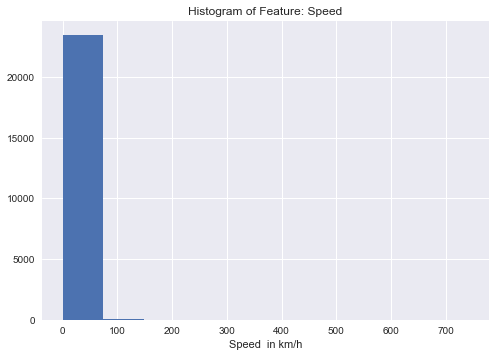

In [39]:
#histogram of speed

df.speed.hist()
plt.title('Histogram of Feature: Speed')
plt.xlabel('Speed  in km/h')


In [40]:
# define plausible speed range
# looks like there are more outliers
min_speed = 4  # walking speed
max_speed = 80 # max allowed speed in quito is 70

df = df[(df['speed']>=min_speed) & (df['speed']<=max_speed)]

# apply selection
features_train = features_train.loc[df.index,:]
target_train = target_train.loc[df.index]

In [41]:
df.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,Quito,speed
count,22667.000000,22667.000000,22667.000000,22667.000000,22667.000000,22667.000000,22667.000000,22667.000000,22667.000000
mean,16208.090396,-78.491644,-0.187322,-78.492154,-0.188713,1015.875281,4899.085322,0.986721,19.448816
std,9330.710602,0.027827,0.055706,0.027704,0.056609,848.887687,3352.116025,0.114470,8.371724
min,5.000000,-78.582119,-0.391084,-78.583936,-0.386281,30.000000,100.000000,0.000000,4.007364
25%,8161.000000,-78.505316,-0.214502,-78.504719,-0.215973,490.500000,2413.000000,1.000000,13.820799
50%,16243.000000,-78.489928,-0.181776,-78.489872,-0.185408,796.000000,4058.000000,1.000000,18.519231
75%,24319.500000,-78.476050,-0.150062,-78.478138,-0.153304,1263.000000,6621.000000,1.000000,23.861096
max,32366.000000,-78.325873,0.015609,-78.333007,0.018878,7126.000000,19223.000000,1.000000,78.837154


Text(0, 0.5, 'wait_sec in sec')

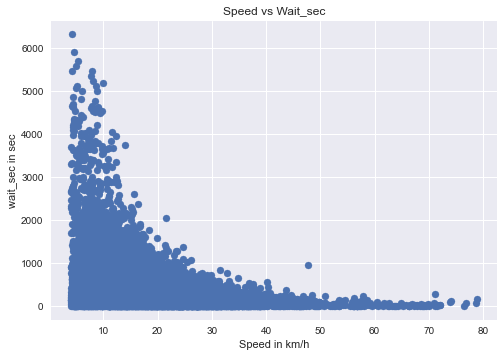

In [42]:
#plot speed against wait_sec
plt.scatter(x=df.loc[:,'speed'],
            y=target_train)
plt.title('Speed vs Wait_sec')
plt.xlabel('Speed in km/h')
plt.ylabel('wait_sec in sec')

In [43]:
# weekend
df['weekend'] = (df['pickup_datetime'].dt.weekday > 5).astype(int)  

In [44]:
# season

def get_season(month):
    """Return if month in dry or wet Season
    
    Dry Season : Jun - Sep
    Wet Season : Oct - May
    
    Args:
        month (int): Month from Datetime
    
    Returns:
        bool: 0 for wet season, 1 for dry season.
    """
    if 9>= month >=6:
        return 0
    return 1   

df['season'] = df['pickup_datetime'].dt.month.apply(get_season)

In [45]:
# calculating haversine distance
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    Args: 
        lon1 (float) : longitude from start location
        lat1 (float) : latitude from start location
        lon2 (float) : longitude from end location
        lat2 (float) : longitude from end location
    
    Returns:
        float: distance between two points on earth
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [46]:
#distance to center using haversine formula

quito_center = (-0.175, -78.5) #longitude, latitude

df["pickup_distance_to_center"] = (df[['pickup_latitude', 'pickup_longitude']].
                                   apply(lambda x: haversine(x[1], 
                                                             x[0], 
                                                             quito_center[1], 
                                                             quito_center[0]), 
                                         axis=1))

df["dropoff_distance_to_center"] = (df[['dropoff_latitude','dropoff_longitude']]
                                      .apply(lambda x: haversine(x[1], 
                                                                 x[0], 
                                                                 quito_center[1], 
                                                                 quito_center[0]),
                                             axis=1))

Text(0.5, 0, 'distance_to_center in km')

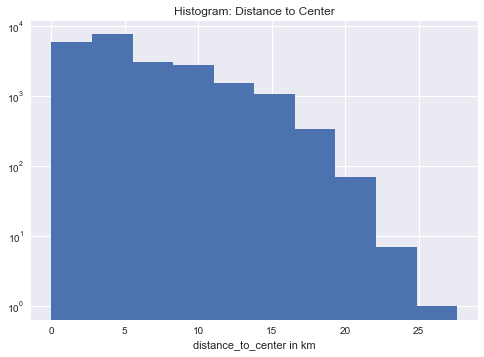

In [47]:
# show histogram of distance to center
df.pickup_distance_to_center.hist()
plt.gca().set_yscale('log')
plt.title('Histogram: Distance to Center')
plt.xlabel('distance_to_center in km')

In [48]:
#going downtown or uptown
df["to_center"] = (df["pickup_distance_to_center"] > df["dropoff_distance_to_center"])

In [49]:
# define engineer_features function
from math import radians, cos, sin, asin, sqrt

def engineer_features(df):
    """Add new Features to Dataframe.
    
    Add 'Quito', 'speed' , 'weekend' , 'season' , pickup_distance_to_center , 
    'dropoff_distance_to_center' , 'to_center', 
    Convert categorical features to one hot representation/ binary
    
    Args:
        df (pd.DataFrame): Dataframe
    
    Returns:
        (pd.DataFrame) : Dataframe with new Features
    """  
    
    #transform vendor_id to binary, call the column 'Quito'
    vendor = (df.vendor_id == 'Quito').astype(int)
    vendor = vendor.astype(float)
    df['Quito'] = vendor
    df = df.drop(['vendor_id'], axis=1)
    
    #drop unnecessary columns
    df = df.drop(['store_and_fwd_flag', 'id'], axis = 1)

    #create new feature speed
    df['speed'] = (df.distance_m / 1000) / (df.trip_estimated / 3600)
    
    #define plausible speed range
    #min_speed = 4  # walking speed
    #max_speed = 80 # max alloews speed in quito is 70

    #df = df[(df['speed']>=min_speed) & (df['speed']<=max_speed)]

    # weekend
    df['weekend'] = (df['pickup_datetime'].dt.weekday > 5).astype(int)
    
    # season
    df['season'] = df['pickup_datetime'].dt.month.apply(get_season)
    # new thing
    df['trip_duration_log'] = np.round(np.log1p(df['trip_estimated']), 5)
    df['dist_meters_log'] = np.round(np.log1p(df['distance_m']), 5)
    df['avg_speed'] = df['distance_m'] / df['trip_estimated'] 
    #distance to center using haversine formula
    quito_center = (-0.175, -78.5) #longitude, latitude

    df["pickup_distance_to_center"] = (df[['pickup_latitude', 'pickup_longitude']].
                                   apply(lambda x: haversine(x[1], 
                                                             x[0], 
                                                             quito_center[1], 
                                                             quito_center[0]), 
                                         axis=1))

    df["dropoff_distance_to_center"] = (df[['dropoff_latitude','dropoff_longitude']]
                                      .apply(lambda x: haversine(x[1], 
                                                                 x[0], 
                                                                 quito_center[1], 
                                                                 quito_center[0]),
                                             axis=1))
    
    #going downtown or uptown
    df["to_center"] = (df["pickup_distance_to_center"] > df["dropoff_distance_to_center"]).astype(int)

    return df

#put custom functions needed for data_engineering here

def get_season(month):
    """Return if month in dry or wet Season
    
    Dry Season : Jun - Sep
    Wet Season : Oct - May
    
    Args:
        month (int): Month from Datetime
    
    Returns:
        str: 0 or 4 according to inputted month.
    """
    if 9>= month >=6:
        return 0
    return 1

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [50]:
#sampling_feature_df function

def sampling_feature_df(features, target):
    """Deals with outliers in new Features,
     after feature engineering step.

     Removing Speed out of range.

     Args:
        features (pd.DataFrame): Dataframe containing outliers
        target (pd.Series) : Series with target values matching to features
    
    Returns:
        (pd.DataFrame) : Filtered features
        (pd.Series) : Filtered target
    """
    #define plausible speed range
    min_speed = 4  # walking speed
    max_speed = 80 # max allowed speed in quito is 70

    features = features[(features['speed']>=min_speed) & (features['speed']<=max_speed)]
    target = target[features.index]
        
    return features, target

In [52]:
# feature selection

feature_cols = ['trip_estimated', 
                'distance_m', 
                'speed', 
                'weekend', 
                'season',
                'pickup_distance_to_center', 
                'to_center']

# Lineaire regression 

In [53]:
# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RANSACRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Validation
from sklearn.model_selection import KFold, cross_val_score, validation_curve, GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.svm import SVC
from statsmodels.robust import mad

In [54]:
# apply clean_data, sampling_data, engineer_features and sampling_feature_df

features_train = clean_data(features_train)
features_train, target_train = sampling_data(features_train, target_train)
features_train = engineer_features(features_train)
features_train, target_train = sampling_feature_df(features_train, target_train)

features_test = clean_data(features_test)
features_test = engineer_features(features_test)

C:\Users\Acer\AppData\Local\Temp/ipykernel_26480/2786108231.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones(len(features), np.bool)
C:\Users\Acer\AppData\Local\Temp/ipykernel_26480/2616129011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
C:\Users\Acer\AppData\Local\Temp/ipykernel_26480/3812490200.py:21: SettingWithCopyWarning: 
A val

In [55]:
#select features
features_train = features_train.loc[:, feature_cols]
features_test = features_test.loc[:, feature_cols]

In [56]:
#linreg

linreg2 = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("linear_regression", LinearRegression(n_jobs=-1))
])
linreg2.fit(features_train, target_train)

#predict
linreg2_predictions = linreg2.predict(features_test)

#evaluate
print("simple linear regression\n-------------")
print("R2 :", r2_score(target_test, linreg2_predictions))
print("MAE :", mean_absolute_error(target_test, linreg2_predictions))

#save model
import pickle
pickle.dump(linreg2, open('linreg2.p', 'wb'))

simple linear regression
-------------
R2 : 0.46792939538443146
MAE : 170.73692288735984


# Support Vector Machine

In [57]:
#SVM

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
#train
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm' , SVR(C=1.0, epsilon=0.2))
    ])
svm.fit(features_train, target_train)

#predict
y_pred = svm.predict(features_test)

#evaluate
print("SVM (regression)\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))

SVM (regression)
-------------
R2 : 0.2274177223209194
MAE : 182.91477748286198


# Ridge 

In [58]:
# Ridge

std_scaler = StandardScaler()
ridge_pipe = Pipeline([('scale', std_scaler),
                       ('model', Ridge(random_state=42,
                                       alpha=0.1))])
param_grid = {'model__alpha': [0.0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_gs = GridSearchCV(estimator=ridge_pipe,
                        param_grid=param_grid, 
                        scoring="neg_mean_absolute_error",
                        n_jobs=-1, 
                        cv=2, 
                        verbose=4)

ridge_gs.fit(features_train, target_train)
          
#predict
y_pred = ridge_gs.predict(features_test)

#evaluate
print("Ridge\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Ridge
-------------
R2 : 0.467929395384431
MAE : 170.73692288735984


# Artificial Neural Network 

In [63]:
#ANN

from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tensorflow

model_ann = Sequential()
model_ann.add(Input(7))
model_ann.add(Dense(units=12, activation='relu'))
model_ann.add(Dropout(rate=0.2))
model_ann.add(Dense(units=8, activation='relu'))
model_ann.add(Dropout(rate=0.2))
model_ann.add(Dense(units=1))

model_ann.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

#train
model_hist = model_ann.fit(features_train, target_train, epochs=30, batch_size=64, validation_split=0.2)

#predict
y_pred = model_ann.predict(features_test)

#evaluate
print("ANN\n-------------")
print("R2 :", r2_score(target_test, y_pred))
print("MAE :", mean_absolute_error(target_test, y_pred))

Epoch 1/30
281/281 [==============================] - 2s 4ms/step - loss: 446.8490 - mse: 557892.7500 - mae: 446.8490 - val_loss: 200.9211 - val_mse: 161925.0312 - val_mae: 200.9211
Epoch 2/30
281/281 [==============================] - 1s 3ms/step - loss: 247.5991 - mse: 201152.2812 - mae: 247.5991 - val_loss: 191.4352 - val_mse: 153360.9531 - val_mae: 191.4352
Epoch 3/30
281/281 [==============================] - 1s 3ms/step - loss: 221.8569 - mse: 174286.6562 - mae: 221.8569 - val_loss: 174.0728 - val_mse: 135786.0000 - val_mae: 174.0728
Epoch 4/30
281/281 [==============================] - 1s 3ms/step - loss: 205.8846 - mse: 151352.2969 - mae: 205.8846 - val_loss: 162.1384 - val_mse: 121685.9922 - val_mae: 162.1384
Epoch 5/30
281/281 [==============================] - 1s 3ms/step - loss: 196.1187 - mse: 140988.6562 - mae: 196.1187 - val_loss: 156.2205 - val_mse: 111394.7734 - val_mae: 156.2205
Epoch 6/30
281/281 [==============================] - 1s 3ms/step - loss: 188.8445 - mse: 

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


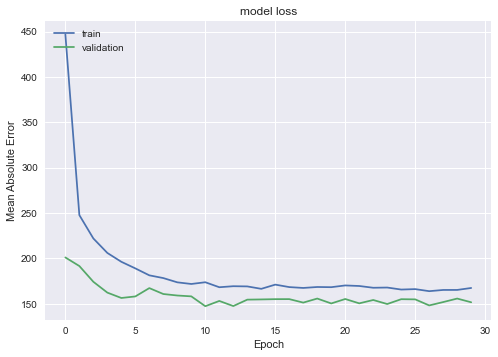

In [64]:
#visualize loss

import matplotlib.pyplot as plt
print(model_hist.history.keys())
# "Loss"
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Ridge model is the best model to predict the data

R2 value of 0.4679 indicates that RIDGE model explains 46.79% of the variance in the target variable.
The mean absolute error (MAE) of 170.74 indicates that, on average, the predicted values from our model are 170.74 seconds away from the actual values. 